# **Import libraries**

In [2]:
import joblib
import warnings

import numpy  as np
import pandas  as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy   import stats

from IPython.display      import Image
from IPython.core.display import HTML

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

# **Data Import and description**

In [4]:
df1 = pd.read_csv('/content/fraud_0.1origbase.csv')

In [5]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


In [6]:
!pip install inflection

import inflection

cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              636262 non-null  int64  
 1   type              636262 non-null  object 
 2   amount            636262 non-null  float64
 3   name_orig         636262 non-null  object 
 4   oldbalance_org    636262 non-null  float64
 5   newbalance_orig   636262 non-null  float64
 6   name_dest         636262 non-null  object 
 7   oldbalance_dest   636262 non-null  float64
 8   newbalance_dest   636262 non-null  float64
 9   is_fraud          636262 non-null  int64  
 10  is_flagged_fraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


# **Data Cleaning**

In [8]:
df1.isna().mean()

,0
step,0.0
type,0.0
amount,0.0
name_orig,0.0
oldbalance_org,0.0
newbalance_orig,0.0
name_dest,0.0
oldbalance_dest,0.0
newbalance_dest,0.0
is_fraud,0.0


In [9]:
# Handle missing values
df1['name_orig'] = df1['name_orig'].fillna(0).astype(str).apply(lambda i: i[0])
df1['name_dest'] = df1['name_dest'].fillna(0).astype(str).apply(lambda i: i[0])


In [10]:
df1['is_fraud'] = df1['is_fraud'].map({1: 'yes', 0: 'no'})
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'})

Feature engineering

In [11]:
df2 = df1.copy()

In [12]:
# step
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']

# name orig and name dest
df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])

Expolatory data analysis

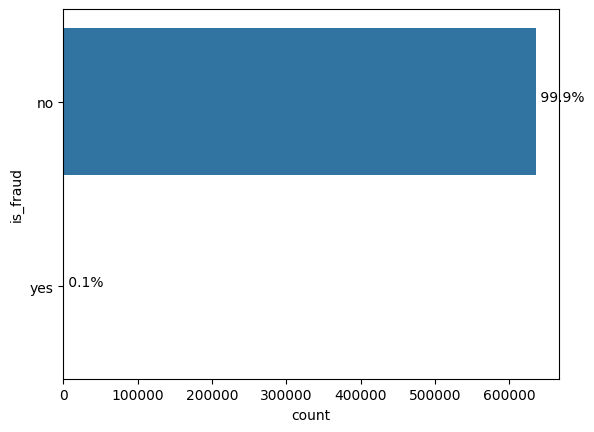

In [13]:
ax = sns.countplot(y='is_fraud', data=df2);

total = df2['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

<Axes: xlabel='amount', ylabel='Density'>

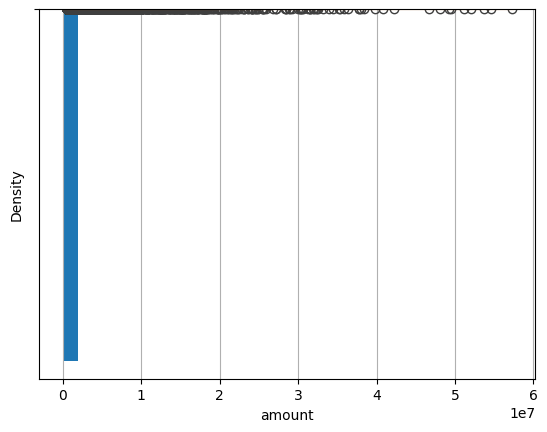

In [14]:
df2['amount'].hist(bins=30)
sns.boxplot(x=df2['amount'])
sns.kdeplot(df2['amount'])

<Axes: xlabel='type', ylabel='count'>

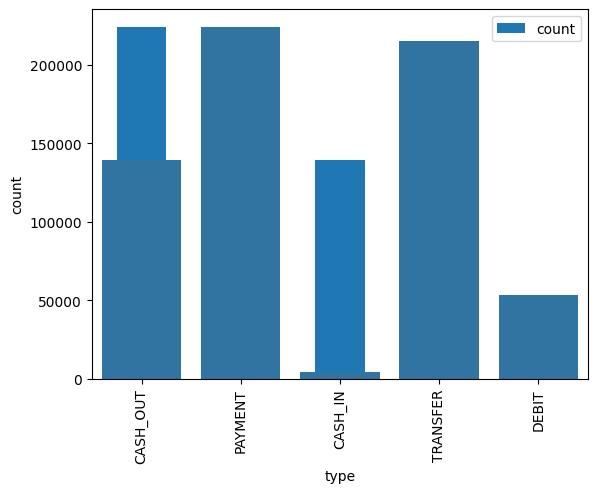

In [15]:
df2['type'].value_counts().plot(kind='bar')
sns.countplot(x='type', data=df2)


<Axes: xlabel='is_fraud', ylabel='amount'>

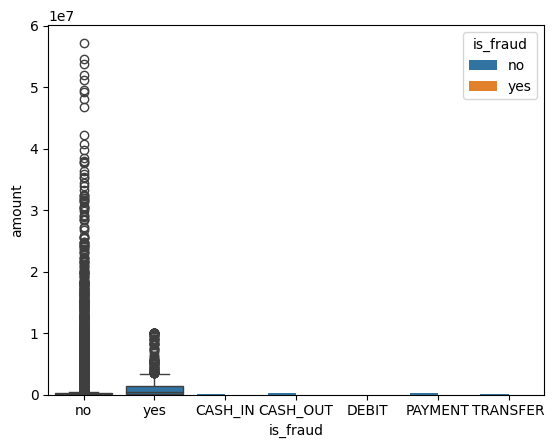

In [16]:
sns.boxplot(x='is_fraud', y='amount', data=df2)
sns.countplot(x='type', hue='is_fraud', data=df2)


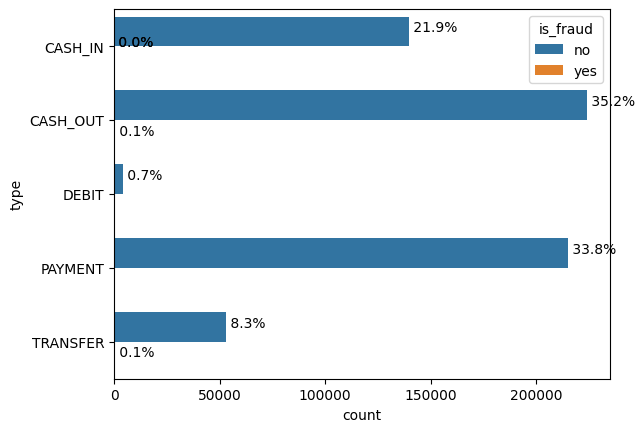

In [17]:
ax = sns.countplot(y='type', hue='is_fraud', data=df2)

total = df2['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))


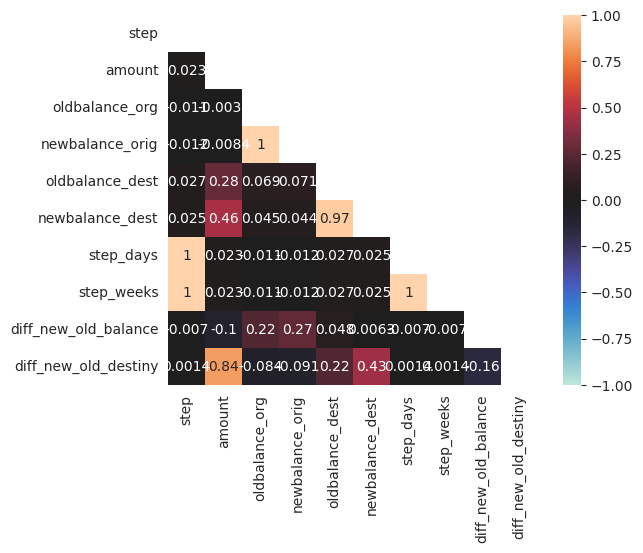

In [18]:
num_attributes = df2.select_dtypes(exclude='object')
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

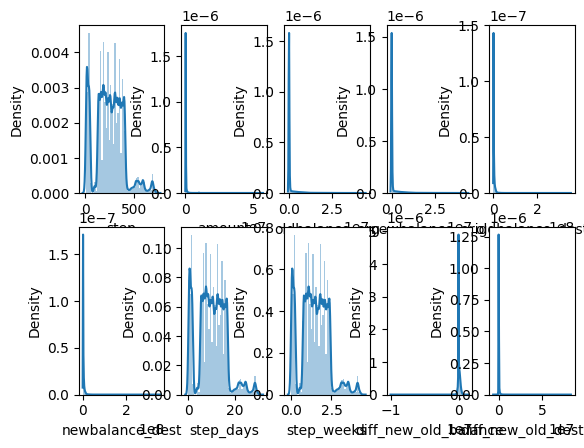

In [19]:
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 5, j)
    sns.distplot(num_attributes[column]);

    j += 1

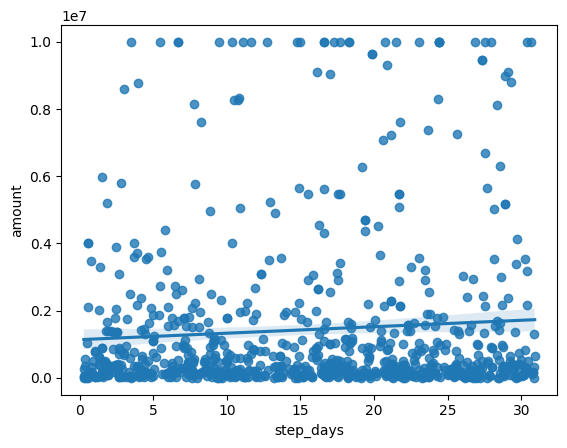

In [20]:
aux1 = df2[df2['is_fraud'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1);

# **Data Preparation**

In [21]:
X = df2.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest',
                      'step_weeks', 'step_days'], axis=1)
y = df2['is_fraud'].map({'yes': 1, 'no': 0})

In [22]:
print(y.isna().sum())
print(X.isna().sum())
y = y.fillna(0)
X = X.fillna(0)

0
step                    0
type                    0
amount                  0
oldbalance_org          0
newbalance_orig         0
oldbalance_dest         0
newbalance_dest         0
diff_new_old_balance    0
diff_new_old_destiny    0
dtype: int64


In [23]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

In [24]:
!pip install category_encoders
from category_encoders import OneHotEncoder

ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 3.0 MB/s eta 0:00:00


In [25]:
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

In [26]:
final_columns_selected = ['step', 'oldbalance_org',
                          'newbalance_orig', 'newbalance_dest',
                          'diff_new_old_balance', 'diff_new_old_destiny',
                          'type_TRANSFER']

In [27]:
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

# **Machine learning modeling**

In [46]:
def ml_cv_results(model_name, model, x, y, verbose=1):

    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []

    mm = MinMaxScaler()

    x_ = x.to_numpy()
    y_ = y.to_numpy()

    count = 0

    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))

        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]

        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)

        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))


    '''results'''
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)

    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

**SVM**

In [29]:
def ml_scores(model_name, y_true, y_pred):

    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3),
                         'Precision': np.round(precision, 3),
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)},
                        index=[model_name])

In [30]:
svm = SVC()
svm.fit(X_train_cs, y_train)

y_pred = svm.predict(X_valid_cs)

In [31]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5,0.0,0.0,0.0,0.0


In [32]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



In [49]:
svm_cv = ml_cv_results('SVM', SVC(), X_temp_cs, y_temp)
svm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.596 +/- 0.023,1.0 +/- 0.0,0.192 +/- 0.046,0.319 +/- 0.065,0.319 +/- 0.065


**Logistic regression**

In [34]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

In [35]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.5,0.0,0.0,0.0,0.0


In [36]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



In [48]:
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(),
                      X_temp_cs, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.537 +/- 0.021,1.0 +/- 0.0,0.074 +/- 0.041,0.136 +/- 0.07,0.136 +/- 0.07


**Random forest**

In [38]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [39]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.84,0.989,0.679,0.805,0.805


In [40]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.99      0.68      0.81       131

    accuracy                           1.00    101802
   macro avg       0.99      0.84      0.90    101802
weighted avg       1.00      1.00      1.00    101802



In [50]:
rf_cv = ml_cv_results('Random Forest',
                      RandomForestClassifier(),
                      X_temp_cs, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.868 +/- 0.014,0.974 +/- 0.014,0.737 +/- 0.028,0.839 +/- 0.019,0.838 +/- 0.019


**KNN**

In [42]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)

In [43]:

knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.565,1.0,0.13,0.23,0.23


In [44]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.13      0.23       131

    accuracy                           1.00    101802
   macro avg       1.00      0.56      0.61    101802
weighted avg       1.00      1.00      1.00    101802



In [47]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(),
                       X_temp_cs, y_temp)
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.704 +/- 0.009,0.934 +/- 0.02,0.408 +/- 0.019,0.568 +/- 0.02,0.567 +/- 0.02


**XGBoost**

In [56]:

xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [57]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.874,0.942,0.748,0.834,0.834


In [58]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.94      0.75      0.83       131

    accuracy                           1.00    101802
   macro avg       0.97      0.87      0.92    101802
weighted avg       1.00      1.00      1.00    101802



In [59]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_temp_cs, y_temp)
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.887 +/- 0.025,0.945 +/- 0.031,0.775 +/- 0.051,0.85 +/- 0.034,0.85 +/- 0.034


# **Compare results**

In [60]:
modeling_performance = pd.concat([lg_results, rf_results,svm_results,knn_results,xgb_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.500,0.000,0.000,0.000,0.000
SVM,0.500,0.000,0.000,0.000,0.000
K Nearest Neighbors,0.565,1.000,0.130,0.230,0.230
Random Forest,0.840,0.989,0.679,0.805,0.805
XGBoost,0.874,0.942,0.748,0.834,0.834


In [61]:
modeling_performance_cv = pd.concat([lg_cv,rf_cv, svm_cv,knn_cv,xgb_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.537 +/- 0.021,1.0 +/- 0.0,0.074 +/- 0.041,0.136 +/- 0.07,0.136 +/- 0.07
SVM,0.596 +/- 0.023,1.0 +/- 0.0,0.192 +/- 0.046,0.319 +/- 0.065,0.319 +/- 0.065
K Nearest Neighbors,0.704 +/- 0.009,0.934 +/- 0.02,0.408 +/- 0.019,0.568 +/- 0.02,0.567 +/- 0.02
Random Forest,0.868 +/- 0.014,0.974 +/- 0.014,0.737 +/- 0.028,0.839 +/- 0.019,0.838 +/- 0.019
XGBoost,0.887 +/- 0.025,0.945 +/- 0.031,0.775 +/- 0.051,0.85 +/- 0.034,0.85 +/- 0.034


# **Hyperparameter Tuning**

In [53]:
f1 = make_scorer(f1_score)

In [54]:
params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}

In [64]:
best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

# **Results**


In [66]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

In [67]:
xgb_gs.fit(X_train_cs, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [68]:
y_pred = xgb_gs.predict(X_valid_cs)

# **Conclusions**

In [69]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_temp)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [70]:
y_pred = final_model.predict(X_test_cs)

In [71]:
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Balanced Accuracy,Precision,Recall,F1,Kappa
unseen,0.912,0.957,0.823,0.885,0.885


# **Model Deployment**

In [73]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_temp)

joblib.dump(final_model, '../content/model_cycle1.joblib')

['../content/model_cycle1.joblib']